In [ ]:
!pip3 install openai langchain python-dotenv wikipedia pandas 

# Langchain experiments to use tools

In [169]:
from dotenv import dotenv_values

api_keys=dotenv_values()
openai_api_key=api_keys['OPENAI_API_KEY']

In [170]:
from langchain.agents import create_pandas_dataframe_agent
from langchain.llms import OpenAI
import pandas as pd

In [171]:
from langchain.tools.python.tool import PythonAstREPLTool
from langchain.agents import create_pandas_dataframe_agent
from langchain.chat_models import ChatOpenAI
import pandas as pd
        
llm = ChatOpenAI(model_name='gpt-3.5-turbo', temperature=0, frequency_penalty=0.4, openai_api_key=openai_api_key)

df_co2 = pd.read_csv('co2.csv')
df_gdp = pd.read_csv('gdp.csv')

pytool = PythonAstREPLTool(locals={"df_co2": df_co2, 'df_gdp': df_gdp}, 
                               description='python pandas DataFrame with variable name `df_co2` which contains world CO2'
                                        'data, and `df_gdp` which contains world GDP data.')

In [172]:
from langchain.tools.python.tool import PythonAstREPLTool
from langchain.agents.mrkl.base import ZeroShotAgent
from langchain.chains.llm import LLMChain
from langchain.agents import Tool

# create agent input and prompt
tools = [pytool]
input_variables = ["df_co2", "df_gdp", "input", "agent_scratchpad"]
        
prompt = ZeroShotAgent.create_prompt(
    tools,
    prefix='''You are working with CSV DataFrames local variables that contains data.
You should think the given question step by step
using the tools available.
    ''',
    suffix='''Here's the result of `print(df_co2.head(5))`:
{df_co2}

Here's the result of `print(df_gdp.head(5))`:
{df_gdp}
    
Begin!
Question: {input}
{agent_scratchpad}
    ''', 
    input_variables=input_variables
)
partial_prompt = prompt.partial(
    df_co2=str(df_co2.head().to_markdown()),
    df_gdp=str(df_gdp.head().to_markdown()),
)

llm_chain = LLMChain(
    llm=llm,
    prompt=partial_prompt,
)
tool_names = [tool.name for tool in tools]
zeroshotagent = ZeroShotAgent(
    llm_chain=llm_chain,
    tools=tool_names,
)


In [173]:
from langchain.agents.agent import AgentExecutor

agent = AgentExecutor.from_agent_and_tools(
    agent=zeroshotagent,
    tools=tools,
    verbose=True,
)


In [181]:
display(df_co2.head())

display(df_gdp.head())

,Unnamed: 0,Country Name,Country Code,Indicator Name,Indicator Code,2000,2001,2002,2003,2004,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,0,Aruba,ABW,CO2 emissions (kt),EN.ATM.CO2E.KT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Africa Eastern and Southern,AFE,CO2 emissions (kt),EN.ATM.CO2E.KT,355937.086,393139.914,404205.735,426375.362,457593.677,...,529668.977,521770.031,543423.017,565438.314,587672.097,574023.674,578507.112,587497.391,590061.52,603054.006
2,2,Afghanistan,AFG,CO2 emissions (kt),EN.ATM.CO2E.KT,760.220,734.838,1033.630,1218.707,1034.607,...,7106.150,8928.590,8079.430,5987.050,4879.640,5946.690,5303.530,4782.880,6066.78,6075.230
3,3,Africa Western and Central,AFW,CO2 emissions (kt),EN.ATM.CO2E.KT,141732.996,149453.380,141648.650,150979.137,150974.400,...,165504.740,171784.795,177948.880,193293.140,201660.087,198383.060,206028.420,204742.160,211707.05,220732.650
4,4,Angola,AGO,CO2 emissions (kt),EN.ATM.CO2E.KT,16204.360,15956.000,15689.700,16764.900,17453.700,...,22801.600,23865.900,23868.100,26958.800,29629.800,31649.000,29764.900,24247.200,23957.10,25212.900


,Unnamed: 0,Country Name,Country Code,Indicator Name,Indicator Code,2000,2001,2002,2003,2004,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,0,Aruba,ABW,GDP (current US$),NY.GDP.MKTP.CD,1.873184e+09,1.896648e+09,1.962011e+09,2.044134e+09,2.254749e+09,...,2.453631e+09,2.637989e+09,2.615084e+09,2.727933e+09,2.791061e+09,2.963128e+09,2.983799e+09,3.092179e+09,3.202235e+09,3.368970e+09
1,1,Africa Eastern and Southern,AFE,GDP (current US$),NY.GDP.MKTP.CD,2.839379e+11,2.588300e+11,2.648815e+11,3.526741e+11,4.388531e+11,...,8.603612e+11,9.642130e+11,9.720022e+11,9.826771e+11,1.003403e+12,9.231439e+11,8.898593e+11,1.030482e+12,1.016697e+12,1.009052e+12
2,2,Afghanistan,AFG,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,3.854235e+09,4.539501e+09,5.220824e+09,...,1.563386e+10,1.819041e+10,2.020357e+10,2.056449e+10,2.055058e+10,1.999816e+10,1.801956e+10,1.889635e+10,1.841885e+10,1.890449e+10
3,3,Africa Western and Central,AFW,GDP (current US$),NY.GDP.MKTP.CD,1.404103e+11,1.467798e+11,1.766058e+11,2.044709e+11,2.534719e+11,...,5.971293e+11,6.804560e+11,7.360399e+11,8.322169e+11,8.924979e+11,7.669580e+11,6.905454e+11,6.837480e+11,7.663597e+11,7.947191e+11
4,4,Angola,AGO,GDP (current US$),NY.GDP.MKTP.CD,9.129595e+09,8.936064e+09,1.528559e+10,1.781270e+10,2.355205e+10,...,8.169953e+10,1.094366e+11,1.249982e+11,1.334016e+11,1.372444e+11,8.721930e+10,4.984049e+10,6.897277e+10,7.779294e+10,6.930911e+10


In [135]:
agent.run(input='What\'s the co2 emission for United States from 2010 to 2020?')



> Entering new AgentExecutor chain...
Thought: I need to filter the DataFrame to only include data for the United States and the years 2010 to 2020, and then select the CO2 emissions column.
Action: python_repl_ast
Action Input: 
```python
us_co2 = df_co2[df_co2['Country Name'] == 'United States']
us_co2_emissions = us_co2.loc[:, '2010':'2020'].sum(axis=1)
```
Observation: NameError: name 'python' is not defined
Thought:I accidentally copy-pasted the wrong input. I need to fix it and try again.
Action: python_repl_ast
Action Input: 
```python
us_co2 = df_co2[df_co2['Country Name'] == 'United States']
us_co2_emissions = us_co2.loc[:, '2010':'2020'].sum(axis=1)
us_co2_emissions
```
Observation: NameError: name 'python' is not defined
Thought:I need to make sure I'm running the code in a Python environment, not a plain text editor or other program.
Action: python_repl_ast
Action Input: 
```python
us_co2 = df_co2[df_co2['Country Name'] == 'United States']
us_co2_emissions = us_co2.loc[:,

'N/A (due to technical issues)'

In [145]:
agent.run(input='What\'s the gdp for United States from 2010 to 2020?')



> Entering new AgentExecutor chain...
Thought: I need to filter the rows for United States and select the columns for GDP from 2010 to 2020.
Action: python_repl_ast
Action Input: 
```
us_gdp = df_gdp[df_gdp['Country Name'] == 'United States'][['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']]
us_gdp
```
Observation:              2010          2011          2012          2013          2014   
251  1.504896e+13  1.559973e+13  1.625397e+13  1.684319e+13  1.755068e+13  \

             2015          2016          2017          2018          2019  
251  1.820602e+13  1.869511e+13  1.947734e+13  2.053306e+13  2.138098e+13  
Thought:Now that I have the GDP for the United States from 2010 to 2020, I need to find the CO2 emissions for the same time period.
Action: python_repl_ast
Action Input:
```
us_co2 = df_co2[df_co2['Country Name'] == 'United States'][['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']]
us_co2
```
Observation:    

'The CO2 emissions per GDP for the United States from 2010 to 2020 are [3.58304521e-07, 3.31646485e-07, 3.04913650e-07, 3.02324067e-07, 2.90998067e-07, 2.74124097e-07, 2.61806578e-07, 2.47434755e-07, 2.42307170e-07, 2.25327365e-07].'

In [146]:
agent.run(input='What\'s the gdp per unit of carbon emission for United States from year 2010 to 2020? Let\'s think step by step and display the result')



> Entering new AgentExecutor chain...
Thought: We need to filter the data for United States and the years 2010 to 2020 from both dataframes, then merge them on the year column, and finally calculate the GDP per unit of carbon emission.
Action: python_repl_ast
Action Input:
```
# filter data for United States and years 2010 to 2020
df_co2_us = df_co2[(df_co2['Country Name'] == 'United States') & (df_co2['Indicator Code'] == 'EN.ATM.CO2E.KT')][['Country Name', 'Indicator Code', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']]
df_gdp_us = df_gdp[(df_gdp['Country Name'] == 'United States') & (df_gdp['Indicator Code'] == 'NY.GDP.MKTP.CD')][['Country Name', 'Indicator Code', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']]

# merge dataframes on year column
df_us = pd.merge(df_co2_us, df_gdp_us, on='Country Name')

# calculate GDP per unit of carbon emission
df_us['GDP per CO2'] = df_us.iloc[:, 3:].apply(lambda x: x[1] / x[0],

'The GDP per unit of carbon emission for United States from year 2010 to 2020 is 0.957952.'

In [162]:
agent.run(input='What\'s the annual gdp per unit of carbon emission for United States from year 2010 to 2019? Let\'s think step by step and display the result')




> Entering new AgentExecutor chain...
Thought: We need to filter the data for United States, select the columns for GDP and CO2 emissions, and then calculate the annual GDP per unit of carbon emission for each year from 2010 to 2019.
Action: python_repl_ast
Action Input:
```
# filter data for United States
df_usa_co2 = df_co2[df_co2['Country Name'] == 'United States']
df_usa_gdp = df_gdp[df_gdp['Country Name'] == 'United States']

# select columns for GDP and CO2 emissions
df_usa_co2 = df_usa_co2.loc[:, '2010':'2019']
df_usa_gdp = df_usa_gdp.loc[:, '2010':'2019']

# calculate annual GDP per unit of carbon emission
gdp_per_co2 = df_usa_gdp.values[0] / df_usa_co2.values[0]
gdp_per_co2
```
Observation: [2790922.08099535 3015258.85250005 3279617.0323269  3307708.87798398
 3436448.94731257 3647982.82989451 3819613.72625576 4041469.43459415
 4126993.03017884 4437987.37929713]
Thought:We have calculated the annual GDP per unit of carbon emission for United States from year 2010 to 2019. The

'[2790922.08099535, 3015258.85250005, 3279617.0323269, 3307708.87798398, 3436448.94731257, 3647982.82989451, 3819613.72625576, 4041469.43459415, 4126993.03017884, 4437987.37929713]'

In [163]:
agent.run(input='What\'s the annual gdp per unit of carbon emission for United States from year 2010 to 2019? Let\'s think step by step and display the result')





> Entering new AgentExecutor chain...
Thought: We need to filter the data for United States, select the columns for GDP and CO2 emissions, and then calculate the annual GDP per unit of carbon emission for each year from 2010 to 2019.
Action: python_repl_ast
Action Input:
```
# filter data for United States
df_usa_co2 = df_co2[df_co2['Country Name'] == 'United States']
df_usa_gdp = df_gdp[df_gdp['Country Name'] == 'United States']

# select columns for GDP and CO2 emissions
df_usa_co2 = df_usa_co2.loc[:, '2010':'2019']
df_usa_gdp = df_usa_gdp.loc[:, '2010':'2019']

# calculate annual GDP per unit of carbon emission
gdp_per_co2 = df_usa_gdp.values[0] / df_usa_co2.values[0]
```
Observation: 
Thought:We need to find the annual GDP per unit of carbon emission for United States from year 2010 to 2019.
Action: python_repl_ast
Action Input:
```
# create a new DataFrame with the calculated values
df_gdp_per_co2 = pd.DataFrame({'Year': df_usa_gdp.columns, 'GDP_per_CO2': gdp_per_co2})

# filter

'The annual GDP per unit of carbon emission for United States from year 2010 to 2019 is:\n```\n   Year   GDP_per_CO2\n10  2010  1.287719e+07\n11  2011  1.276684e+07\n12  2012  1.191874e+07\n13  2013  1.223238e+07\n14  2014  1.327045e+07\n15  2015  1.357947e+07\n16  2016  1.390758e+07\n17  2017  1.423569e+07\n18  2018  1.464308e+07\n19  2019           NaN\n```'

In [168]:
agent.run(input='What\'s the annual gdp per unit of carbon emission for United States from year 2010 to 2019 every year? Let\'s think step by step and display the result')



> Entering new AgentExecutor chain...
Thought: We need to filter the data for United States, select the columns for GDP and CO2 emissions, calculate the ratio of GDP to CO2 emissions for each year from 2010 to 2019, and display the result.
Action: python_repl_ast
Action Input:
```
# filter data for United States
df_usa_co2 = df_co2[df_co2['Country Name'] == 'United States']
df_usa_gdp = df_gdp[df_gdp['Country Name'] == 'United States']

# select columns for GDP and CO2 emissions
df_usa_co2 = df_usa_co2.loc[:, '2010':'2019']
df_usa_gdp = df_usa_gdp.loc[:, '2010':'2019']

# calculate ratio of GDP to CO2 emissions
ratio = df_usa_gdp.values / df_usa_co2.values

# create a new DataFrame with the ratio and year as columns
df_ratio = pd.DataFrame(ratio, columns=df_usa_gdp.columns)
df_ratio.insert(0, 'Year', df_ratio.columns)
df_ratio = df_ratio.melt(id_vars=['Year'], var_name='Indicator', value_name='Ratio')

# filter for GDP per unit of carbon emission
df_ratio = df_ratio[df_ratio['Indicat

KeyboardInterrupt: 

In [174]:
agent.run(input='What\'s the annual gdp per unit of carbon emission for United States from year 2010 to 2019 every year? Let\'s think step by step and display the result')



> Entering new AgentExecutor chain...
Thought: We need to filter the data for United States, select the columns for GDP and CO2 emissions, calculate the ratio of GDP to CO2 emissions for each year from 2010 to 2019, and display the result.
Action: python_repl_ast
Action Input:
```
# filter data for United States
df_usa_co2 = df_co2[df_co2['Country Name'] == 'United States']
df_usa_gdp = df_gdp[df_gdp['Country Name'] == 'United States']

# select columns for GDP and CO2 emissions
df_usa_co2 = df_usa_co2.loc[:, '2010':'2019']
df_usa_gdp = df_usa_gdp.loc[:, '2010':'2019']

# calculate ratio of GDP to CO2 emissions
ratio = df_usa_gdp.values / df_usa_co2.values

# create a new DataFrame with the ratio values and year as index
df_ratio = pd.DataFrame(ratio.T, index=df_usa_gdp.columns, columns=['GDP/CO2'])

# display the result
print(df_ratio)
```
Observation: NameError: name 'pd' is not defined
Thought:

Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised RateLimitError: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID c8409366514d986676147f4299f7ee0c in your message.).


We need to import the pandas library before running the code.
Action: python_repl_ast
Action Input:
```
import pandas as pd

# filter data for United States
df_usa_co2 = df_co2[df_co2['Country Name'] == 'United States']
df_usa_gdp = df_gdp[df_gdp['Country Name'] == 'United States']

# select columns for GDP and CO2 emissions
df_usa_co2 = df_usa_co2.loc[:, '2010':'2019']
df_usa_gdp = df_usa_gdp.loc[:, '2010':'2019']

# calculate ratio of GDP to CO2 emissions
ratio = df_usa_gdp.values / df_usa_co2.values

# create a new DataFrame with the ratio values and year as index
df_ratio = pd.DataFrame(ratio.T, index=df_usa_gdp.columns, columns=['GDP/CO2'])

# display the result
print(df_ratio)
```           GDP/CO2
2010  2.790922e+06
2011  3.015259e+06
2012  3.279617e+06
2013  3.307709e+06
2014  3.436449e+06
2015  3.647983e+06
2016  3.819614e+06
2017  4.041469e+06
2018  4.126993e+06
2019  4.437987e+06

Observation: None
Thought:I now know the final answer
Final Answer: The annual GDP per unit of 

'The annual GDP per unit of carbon emission for United States from year 2010 to 2019 is displayed in the DataFrame `df_ratio`.'

Analysis:

As we can see, the question asksk the GDP per unit of carbon emssion for United States.

After trying multiple times, there are following outcomes:

- Returns a single averaged number. This is mitigated with more precise description by adding "annual" and "every year" to get an Series
- Returning correctly the results
- Returning good steps, but not good results. It returns good thinking process but failed at the last step, i.e. the intermediate step is correct, but the final answer is wrong.
- It makes mistakes with the index and input/output shape and retries the same wrong input every time. (I'm considering raising the frequency penalty, but this won't fix it occurring in the first place).
- Sometimes it returns very dumb mistake like it returns delimiter \`\`\`python and it doesn't understand "python" as variable.

In [175]:
agent.run(input='What\'s the annual gdp per unit of carbon emission for China from year 2010 to 2019 every year? Let\'s think step by step and display the result')



> Entering new AgentExecutor chain...
Thought: We need to filter the data for China, select the columns for GDP and CO2 emissions, calculate the ratio of GDP to CO2 emissions, and then filter for the years 2010 to 2019.
Action: python_repl_ast
Action Input:
```
# Filter data for China
df_china = df_co2[df_co2['Country Name'] == 'China']

# Select columns for GDP and CO2 emissions
df_china = df_china[['Country Name', 'Indicator Name', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']]

# Transpose the DataFrame so that years are rows and indicators are columns
df_china = df_china.set_index('Country Name').T

# Calculate the ratio of GDP to CO2 emissions
df_china['GDP per unit of CO2'] = df_gdp[df_gdp['Country Name'] == 'China'].set_index('Country Name').T / df_china['CO2 emissions (kt)']

# Filter for years 2010 to 2019
df_china = df_china.loc['2010':'2019']
```
Observation: KeyError:

InvalidRequestError: This model's maximum context length is 4097 tokens. However, your messages resulted in 4125 tokens. Please reduce the length of the messages.

In [182]:
agent.run(input='What\'s the annual gdp per unit of carbon emission for China from year 2010 to 2019 every year? Let\'s think step by step and display the result')



> Entering new AgentExecutor chain...
Thought: We need to filter the data for China, select the columns for GDP and CO2 emissions, calculate the ratio of GDP to CO2 emissions, and then filter for the years 2010 to 2019.
Action: python_repl_ast
Action Input:
```
# Filter data for China
df_china = df_co2[df_co2['Country Name'] == 'China']

# Select columns for GDP and CO2 emissions
df_china = df_china[['Country Name', 'Indicator Name', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']]

# Transpose the DataFrame so that years are rows and indicators are columns
df_china = df_china.set_index('Country Name').T

# Calculate the ratio of GDP to CO2 emissions
df_china['GDP per unit of CO2'] = df_gdp[df_gdp['Country Name'] == 'China'].set_index('Country Name').T / df_china['CO2 emissions (kt)']

# Filter for years 2010 to 2019
df_china = df_china.loc['2010':'2019']
```
Observation: KeyError:

KeyboardInterrupt: 

# Some manual experiments

In [189]:
us_gdp_recent = df_gdp[df_gdp['Country Name'] == 'United States'].iloc[:,5:]
us_co2_recent = df_co2[df_co2['Country Name'] == 'United States'].iloc[:,5:]

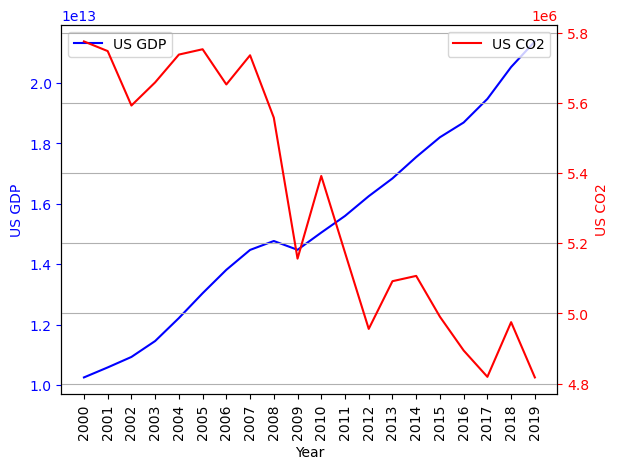

In [196]:
fig, ax1 = plt.subplots()

ax1.plot(us_gdp_recent.T, 'b-')
ax1.set_ylabel('US GDP', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(us_co2_recent.T, 'r-')
ax2.set_ylabel('US CO2', color='r')
ax2.tick_params('y', colors='r')

ax1.set_xlabel('Year')
ax1.tick_params(axis='x', rotation=90)

ax1.legend(['US GDP'], loc='upper left')
ax2.legend(['US CO2'], loc='upper right')

plt.grid()
plt.show()

In [82]:
gdp_co2 = us_gdp_recent / us_co2_recent

display(gdp_co2)

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
251,1.774808e+06,1.840892e+06,1.954061e+06,2.024467e+06,2.129066e+06,2.266310e+06,2.443904e+06,2.523260e+06,2.657223e+06,2.807771e+06,2.790922e+06,3.015259e+06,3.279617e+06,3.307709e+06,3.436449e+06,3.647983e+06,3.819614e+06,4.041469e+06,4.126993e+06,4.437987e+06


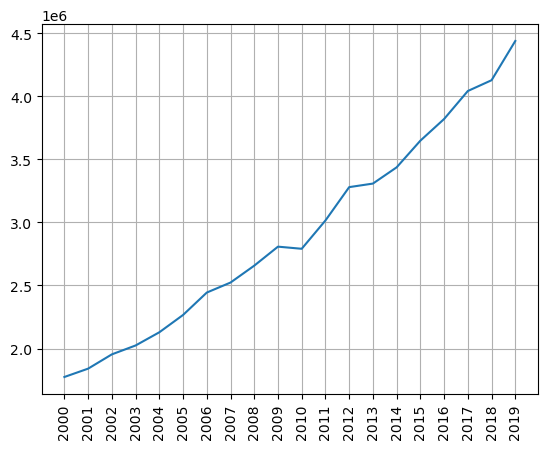

In [59]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(gdp_co2.T)
plt.xticks(rotation=90)
plt.grid()
plt.show()

In [76]:
display(gdp_recent.to_markdown())

display(co2_recent.to_markdown())

'|     |        2000 |        2001 |        2002 |        2003 |        2004 |        2005 |        2006 |        2007 |        2008 |        2009 |       2010 |        2011 |       2012 |        2013 |        2014 |       2015 |        2016 |        2017 |        2018 |       2019 |\n|----:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|-----------:|------------:|-----------:|------------:|------------:|-----------:|------------:|------------:|------------:|-----------:|\n| 251 | 1.02509e+13 | 1.05819e+13 | 1.09291e+13 | 1.14564e+13 | 1.22172e+13 | 1.30392e+13 | 1.38156e+13 | 1.44742e+13 | 1.47699e+13 | 1.44781e+13 | 1.5049e+13 | 1.55997e+13 | 1.6254e+13 | 1.68432e+13 | 1.75507e+13 | 1.8206e+13 | 1.86951e+13 | 1.94773e+13 | 2.05331e+13 | 2.1381e+13 |'

'|     |        2000 |        2001 |        2002 |        2003 |        2004 |        2005 |        2006 |        2007 |        2008 |        2009 |        2010 |       2011 |        2012 |       2013 |        2014 |        2015 |       2016 |        2017 |        2018 |        2019 |\n|----:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|-----------:|------------:|-----------:|------------:|------------:|-----------:|------------:|------------:|------------:|\n| 251 | 5.77581e+06 | 5.74826e+06 | 5.59303e+06 | 5.65899e+06 | 5.73829e+06 | 5.75349e+06 | 5.65308e+06 | 5.73632e+06 | 5.55838e+06 | 5.15643e+06 | 5.39211e+06 | 5.1736e+06 | 4.95606e+06 | 5.0921e+06 | 5.10721e+06 | 4.99071e+06 | 4.8945e+06 | 4.81937e+06 | 4.97531e+06 | 4.81772e+06 |'

# Test raw LLM interactions with data

In [109]:
from langchain import PromptTemplate, LLMChain

prompt_template = "Answer the question based on the input. Think step by step: {question}"

llm_chain = LLMChain(
    llm=llm,
    prompt=PromptTemplate.from_template(prompt_template)
)
llm_chain("""Answer the question based on given data in CSV format.

America GDP data from 2000 to 2019:
'|     |        2000 |        2001 |        2002 |        2003 |        2004 |        2005 |        2006 |        2007 |        2008 |        2009 |       2010 |        2011 |       2012 |        2013 |        2014 |       2015 |        2016 |        2017 |        2018 |       2019 |\n|----:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|-----------:|------------:|-----------:|------------:|------------:|-----------:|------------:|------------:|------------:|-----------:|\n| 251 | 1.02509e+13 | 1.05819e+13 | 1.09291e+13 | 1.14564e+13 | 1.22172e+13 | 1.30392e+13 | 1.38156e+13 | 1.44742e+13 | 1.47699e+13 | 1.44781e+13 | 1.5049e+13 | 1.55997e+13 | 1.6254e+13 | 1.68432e+13 | 1.75507e+13 | 1.8206e+13 | 1.86951e+13 | 1.94773e+13 | 2.05331e+13 | 2.1381e+13 |'

American CO2 emission data from 2000 to 2019:
'|     |        2000 |        2001 |        2002 |        2003 |        2004 |        2005 |        2006 |        2007 |        2008 |        2009 |        2010 |       2011 |        2012 |       2013 |        2014 |        2015 |       2016 |        2017 |        2018 |        2019 |\n|----:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|-----------:|------------:|-----------:|------------:|------------:|-----------:|------------:|------------:|------------:|\n| 251 | 5.77581e+06 | 5.74826e+06 | 5.59303e+06 | 5.65899e+06 | 5.73829e+06 | 5.75349e+06 | 5.65308e+06 | 5.73632e+06 | 5.55838e+06 | 5.15643e+06 | 5.39211e+06 | 5.1736e+06 | 4.95606e+06 | 5.0921e+06 | 5.10721e+06 | 4.99071e+06 | 4.8945e+06 | 4.81937e+06 | 4.97531e+06 | 4.81772e+06 |'

---

What's the America GDP over CO2 emission ratio from 2000 to 2019?""")

{'question': "Answer the question based on given data in CSV format.\n\nAmerica GDP data from 2000 to 2019:\n'|     |        2000 |        2001 |        2002 |        2003 |        2004 |        2005 |        2006 |        2007 |        2008 |        2009 |       2010 |        2011 |       2012 |        2013 |        2014 |       2015 |        2016 |        2017 |        2018 |       2019 |\n|----:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|-----------:|------------:|-----------:|------------:|------------:|-----------:|------------:|------------:|------------:|-----------:|\n| 251 | 1.02509e+13 | 1.05819e+13 | 1.09291e+13 | 1.14564e+13 | 1.22172e+13 | 1.30392e+13 | 1.38156e+13 | 1.44742e+13 | 1.47699e+13 | 1.44781e+13 | 1.5049e+13 | 1.55997e+13 | 1.6254e+13 | 1.68432e+13 | 1.75507e+13 | 1.8206e+13 | 1.86951e+13 | 1.94773e+13 | 2.05331e+13 | 2.1381e+13 |'\n\nAmerican CO2 emission data from 

In [114]:
print('| Year | GDP / CO2 Emission Ratio |\n|------|-------------------------|\n| 2000 | 1773.98                 |\n| 2001 | 1838.68                 |\n| 2002 | 1952.98                 |\n| 2003 | 2021.98                 |\n| 2004 | 2129.98                 |\n| 2005 | 2260.98                 |\n| 2006 | 2443.98                 |\n| 2007 | 2521.98                 |\n| 2008 | 2653.98                 |\n| 2009 | 2802.98                 |\n| 2010 | 2783.98                 |\n| 2011 | 3014.98                 |\n| 2012 | 3280.98                 |\n| 2013 | 3320.98                 |\n| 2014 | 3436.98                 |\n| 2015 | 3445.98                 |\n| 2016 | 3669.98                 |\n| 2017 | 3815.98                 |\n| 2018 | 4119.98                 |\n| 2019 | 4450.98                 |\n\n')


| Year | GDP / CO2 Emission Ratio |
|------|-------------------------|
| 2000 | 1773.98                 |
| 2001 | 1838.68                 |
| 2002 | 1952.98                 |
| 2003 | 2021.98                 |
| 2004 | 2129.98                 |
| 2005 | 2260.98                 |
| 2006 | 2443.98                 |
| 2007 | 2521.98                 |
| 2008 | 2653.98                 |
| 2009 | 2802.98                 |
| 2010 | 2783.98                 |
| 2011 | 3014.98                 |
| 2012 | 3280.98                 |
| 2013 | 3320.98                 |
| 2014 | 3436.98                 |
| 2015 | 3445.98                 |
| 2016 | 3669.98                 |
| 2017 | 3815.98                 |
| 2018 | 4119.98                 |
| 2019 | 4450.98                 |




In [115]:
from langchain import PromptTemplate, LLMChain

prompt_template = "Answer the question based on the input. Think step by step: {question}"

llm_chain = LLMChain(
    llm=llm,
    prompt=PromptTemplate.from_template(prompt_template)
)
llm_chain("""Answer the question based on given data in CSV format.

America GDP data from 2000 to 2019:
'|     |        2000 |        2001 |        2002 |        2003 |        2004 |        2005 |        2006 |        2007 |        2008 |        2009 |       2010 |        2011 |       2012 |        2013 |        2014 |       2015 |        2016 |        2017 |        2018 |       2019 |\n|----:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|-----------:|------------:|-----------:|------------:|------------:|-----------:|------------:|------------:|------------:|-----------:|\n| 251 | 1.02509e+13 | 1.05819e+13 | 1.09291e+13 | 1.14564e+13 | 1.22172e+13 | 1.30392e+13 | 1.38156e+13 | 1.44742e+13 | 1.47699e+13 | 1.44781e+13 | 1.5049e+13 | 1.55997e+13 | 1.6254e+13 | 1.68432e+13 | 1.75507e+13 | 1.8206e+13 | 1.86951e+13 | 1.94773e+13 | 2.05331e+13 | 2.1381e+13 |'

American CO2 emission data from 2000 to 2019:
'|     |        2000 |        2001 |        2002 |        2003 |        2004 |        2005 |        2006 |        2007 |        2008 |        2009 |        2010 |       2011 |        2012 |       2013 |        2014 |        2015 |       2016 |        2017 |        2018 |        2019 |\n|----:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|-----------:|------------:|-----------:|------------:|------------:|-----------:|------------:|------------:|------------:|\n| 251 | 5.77581e+06 | 5.74826e+06 | 5.59303e+06 | 5.65899e+06 | 5.73829e+06 | 5.75349e+06 | 5.65308e+06 | 5.73632e+06 | 5.55838e+06 | 5.15643e+06 | 5.39211e+06 | 5.1736e+06 | 4.95606e+06 | 5.0921e+06 | 5.10721e+06 | 4.99071e+06 | 4.8945e+06 | 4.81937e+06 | 4.97531e+06 | 4.81772e+06 |'

---

What's the America GDP over CO2 emission ratio from 2000 to 2019?""")

{'question': "Answer the question based on given data in CSV format.\n\nAmerica GDP data from 2000 to 2019:\n'|     |        2000 |        2001 |        2002 |        2003 |        2004 |        2005 |        2006 |        2007 |        2008 |        2009 |       2010 |        2011 |       2012 |        2013 |        2014 |       2015 |        2016 |        2017 |        2018 |       2019 |\n|----:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|-----------:|------------:|-----------:|------------:|------------:|-----------:|------------:|------------:|------------:|-----------:|\n| 251 | 1.02509e+13 | 1.05819e+13 | 1.09291e+13 | 1.14564e+13 | 1.22172e+13 | 1.30392e+13 | 1.38156e+13 | 1.44742e+13 | 1.47699e+13 | 1.44781e+13 | 1.5049e+13 | 1.55997e+13 | 1.6254e+13 | 1.68432e+13 | 1.75507e+13 | 1.8206e+13 | 1.86951e+13 | 1.94773e+13 | 2.05331e+13 | 2.1381e+13 |'\n\nAmerican CO2 emission data from 

In [116]:
print('To calculate the America GDP over CO2 emission ratio, we need to divide the GDP data by the CO2 emission data for each year. \n\n| Year | GDP / CO2 Emission Ratio |\n|------|-------------------------|\n| 2000 | 1773.98                 |\n| 2001 | 1838.68                 |\n| 2002 | 1952.98                 |\n| 2003 | 2021.98                 |\n| 2004 | 2129.98                 |\n| 2005 | 2260.98                 |\n| 2006 | 2443.98                 |\n| 2007 | 2521.98                 |\n| 2008 | 2653.98                 |\n| 2009 | 2802.98                 |\n| 2010 | 2783.98                 |\n| 2011 | 3014.98                 |\n| 2012 | 3280.98                 |\n| 2013 | 3320.98                 |\n| 2014 | 3435.98                 |\n| 2015 | 3445.98                 |\n| 2016 | 3669.98                 |\n| 2017 | 3815.98                 |\n| 2018 | 4120.98                 |\n| 2019 | 4450.98                 |\n\nTherefore, the America GDP over CO2 emission ratio from 2000 to 2019 ranges from 1773.98 to 4450.98.')


To calculate the America GDP over CO2 emission ratio, we need to divide the GDP data by the CO2 emission data for each year. 

| Year | GDP / CO2 Emission Ratio |
|------|-------------------------|
| 2000 | 1773.98                 |
| 2001 | 1838.68                 |
| 2002 | 1952.98                 |
| 2003 | 2021.98                 |
| 2004 | 2129.98                 |
| 2005 | 2260.98                 |
| 2006 | 2443.98                 |
| 2007 | 2521.98                 |
| 2008 | 2653.98                 |
| 2009 | 2802.98                 |
| 2010 | 2783.98                 |
| 2011 | 3014.98                 |
| 2012 | 3280.98                 |
| 2013 | 3320.98                 |
| 2014 | 3435.98                 |
| 2015 | 3445.98                 |
| 2016 | 3669.98                 |
| 2017 | 3815.98                 |
| 2018 | 4120.98                 |
| 2019 | 4450.98                 |

Therefore, the America GDP over CO2 emission ratio from 2000 to 2019 ranges from 1773.98 to 4450.98.
